In [1]:
!pip install cirq --pre

In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import recirq.mbl_dtc as dtc_utils

In [3]:
# Variables used across all figures

# define the qubits we'll be using
qubit_locations = [(3, 9), (3, 8), (3, 7), (4, 7), (4, 8), (5, 8), (5, 7), (5, 6), (6, 6), (6, 5), (7, 5), (8, 5),
              (8, 4), (8, 3), (7, 3), (6, 3)]

qubits = [cirq.GridQubit(*idx) for idx in qubit_locations]
num_qubits = len(qubits)

# prepare our DTC circuit list, with 0 through 100 cycles
num_cycles = 100
circuit_list = dtc_utils.symbolic_dtc_circuit_list(qubits=qubits, cycles=num_cycles)

In [4]:
%%time
# Figure 3d

def signal_ratio(zeta_1: np.ndarray, zeta_2: np.ndarray): 
    ''' calculate signal ratio
    Args: 
    - zeta_1: signal (`np.ndarray` of shape (qubits, cycles) to represent polarization over time)
    - zeta 2: signal (`np.ndarray` of shape (qubits, cycles) to represent polarization over time)
    Returns: 
    - computed ratio signal of zeta_1 and zeta_2 (`np.ndarray` of shape (qubits, cycles) to represent polarization over time)
    '''

    return np.abs(zeta_1 - zeta_2)/(np.abs(zeta_1) + np.abs(zeta_2))

# prepare two initial states to compare
disturb_qubit = 11
polarized_initial_state = np.full(num_qubits, 0)
disturbed_polarized_initial_state = polarized_initial_state.copy()
disturbed_polarized_initial_state[disturb_qubit] = 1
initial_states = [polarized_initial_state, disturbed_polarized_initial_state]
initial_state_instances = len(initial_states)

# we have different disorder instances for the two initial states
disorder_instances_options = [64, 81]

# constant for thermalization (g) and fixed phi option
g = 0.94
fixed_phi = -0.4

# collect polarizations first
all_average_polarizations = []

# iterate over initial states and their associated number of disorder instances
for initial_state, disorder_instances in zip(initial_states, disorder_instances_options): 
    
    # expand thermalization constant for each disorder instance
    gs = np.full(disorder_instances, g)

    # parameters for two-qubit FSim gates
    # zeros for theta, zeta, chi
    thetas = np.zeros((disorder_instances, num_qubits))
    zetas = np.zeros((disorder_instances, num_qubits))
    chis = np.zeros((disorder_instances, num_qubits))

    # disorder parameters h and phi 
    local_fields = np.random.uniform(-1.0, 1.0, (disorder_instances, num_qubits))
    disordered_phis = np.random.uniform(-1.5*np.pi, -0.5*np.pi, (disorder_instances, num_qubits))

    # expand fixed phis for all instances and qubits
    fixed_phis = np.full((disorder_instances, num_qubits), fixed_phi)

    # expand initial states for each disorder instance
    initial_state_array = np.asarray([initial_state] * disorder_instances)

    average_polarizations_by_phi = []
    for random_phi in [True, False]:
        # use either random, disordered phis or fixed ones
        if random_phi: 
            phis = disordered_phis
        else: 
            phis = fixed_phis

        # gammas dependent on phis
        gammas = -1/2*phis

        # prepare param resolver
        param_resolvers = dtc_utils.dtc_param_resolver_sweep(gs, initial_state_array, local_fields, thetas, zetas, chis, gammas, phis)

        # simulate and get probabilities
        probabilities = np.asarray(list(dtc_utils.simulate_dtc_circuit_list_sweep(circuit_list, param_resolvers, qubits)))

        # turn probabilities into polarizations, this time not relative to initial state
        polarizations = dtc_utils.get_polarizations(probabilities, num_qubits, probabilities_axis=2)

        # average over disorder instances
        average_polarizations = np.mean(polarizations, axis=0)

        # store average polarizations
        average_polarizations_by_phi.append(average_polarizations)

    # store phi average polarizations
    all_average_polarizations.append(average_polarizations_by_phi)


CPU times: user 16min 21s, sys: 14.5 s, total: 16min 36s
Wall time: 16min 36s


CPU times: user 67.9 ms, sys: 125 µs, total: 68.1 ms
Wall time: 74.9 ms


<timed exec>:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


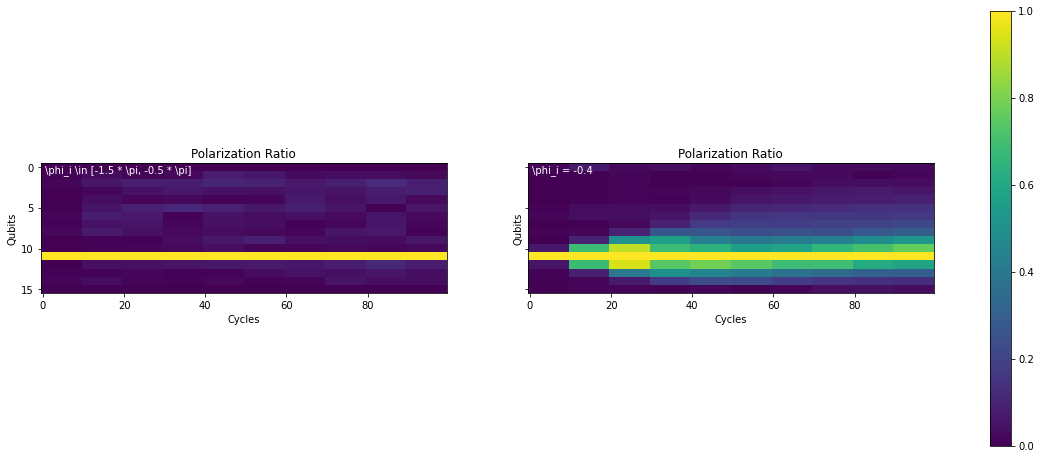

In [5]:
%%time
# the size of window to average cycles over
cycle_window = 10

# prepare subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True, sharex=True)

# switch order to iterate over different phi first, then different initial states
all_average_polarizations_by_phi = list(zip(*all_average_polarizations))

for average_polarizations, axis in zip(all_average_polarizations_by_phi, axes):

    # compare the two polarization signals with signal_ratio
    polarization_ratio = signal_ratio(*average_polarizations)

    # define window indices
    subdivisions = np.arange(cycle_window, num_cycles + 1, cycle_window)

    # divide into cycles_window width sections and discard a final window that isn't full size
    polarization_ratio_windows = np.split(polarization_ratio, subdivisions, axis=0)
    if not polarization_ratio_windows[0].shape == polarization_ratio_windows[-1].shape: 
        polarization_ratio_windows = polarization_ratio_windows[:-1]
    
    # stack windows into a new axis
    polarization_ratio_by_windows = np.stack(polarization_ratio_windows, axis=0)
    
    # average over cycle windows
    average_polarization_ratio_by_windows = np.mean(polarization_ratio_by_windows, axis=1)

    # repeat along the cycles axis, to return to original shape
    average_polarization_ratio = np.repeat(average_polarization_ratio_by_windows, cycle_window, axis=0)

    # plot polarizations as an image
    artist = axis.imshow(average_polarization_ratio.T, aspect = 2.0, vmin=0, vmax=1.0)

    # add labels and colorbar and title
    axis.set_xlabel('Cycles')
    axis.set_ylabel('Qubits')
    axis.set_title('Polarization Ratio')
    
# add colorbar
fig.colorbar(artist, ax=axes.ravel().tolist())

# set phi labels
phi_labels = ['\phi_i \in [-1.5 * \pi, -0.5 * \pi]', '\phi_i = -0.4']

# add phi labels
for phi_label, axis in zip(phi_labels, axes): 
    fig.text(0.01, 0.99, phi_label, horizontalalignment='left', verticalalignment='top', transform=axis.transAxes, color='white')

# show figure
fig.show()


['\\phi_i \\in [-1.5 * \\pi, -0.5 * \\pi]', '\\phi_i = -0.4']


/tmp/ipykernel_459215/553033766.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


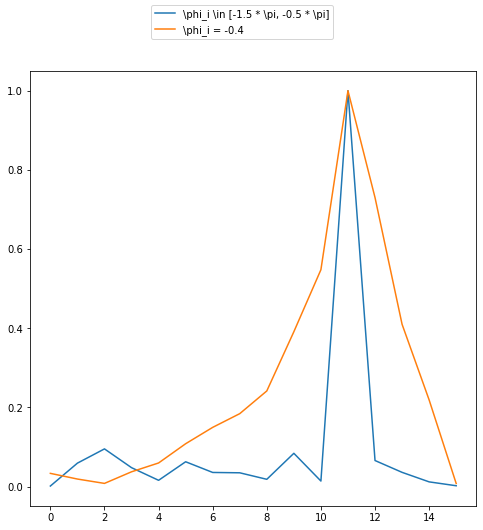

In [6]:
# Slice graph

# prepare subplots
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

print(phi_labels)
for average_polarizations, phi_label in zip(all_average_polarizations_by_phi, phi_labels):

    # compare the two polarization signals with signal_ratio
    polarization_ratio = signal_ratio(*average_polarizations)

    # only consider one window's worth of cycles
    restricted_polarization_ratio = polarization_ratio[51:61, :]

    # average over cycles
    average_polarization_ratio = np.mean(restricted_polarization_ratio, axis=0)
    
    # plot line
    axis.plot(average_polarization_ratio, label=phi_label)

# add legend and show figure
fig.legend(loc='upper center')
fig.show()